In [ ]:
import matplotlib as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os
import pywt
from scipy import signal
import math
from math import *
from PyEMD import EMD
from numpy import ndarray
from numpy import *
import sys
import wden

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier

import tensorflow

import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
from keras.optimizers import SGD

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
#Extract 1 wave from each signal
def extract_signal (array):
    peak = signal.argrelmax(array, order = 500 )
    start = peak[0][1] - 500
    end = peak[0][1] + 3500
    return start, end

In [ ]:
def baseline_corr(array):
    # Function for use in baseline removal
    def wrcoef(X, coef_type, coef, wavename, level):
        N = np.array(X).size
        a, ds = coef[0], list(reversed(coef[1:]))

        if coef_type =='a':
            return pywt.upcoef('a', a, wavename, level=level)[:N]
        elif coef_type == 'd':
            return pywt.upcoef('d', ds[level-1], wavename, level=level)[:N]
        else:
            raise ValueError("Invalid coefficient type: {}".format(coef_type))
    #Baseline correction variables
    wavename = 'db1'
    #Baseline correction
    coef = pywt.wavedec(array, wavename, level=10)
    A10 = wrcoef(array, 'a', coef, wavename, 10)
    D10 = wrcoef(array, 'd', coef, wavename, 10)
    D9 = wrcoef(array, 'd', coef, wavename, 9)
    D8 = wrcoef(array, 'd', coef, wavename, 8)
    D7 = wrcoef(array, 'd', coef, wavename, 7)
    D6 = wrcoef(array, 'd', coef, wavename, 6)
    D5 = wrcoef(array, 'd', coef, wavename, 5)
    D4 = wrcoef(array, 'd', coef, wavename, 4)
    D3 = wrcoef(array, 'd', coef, wavename, 3)
    D2 = wrcoef(array, 'd', coef, wavename, 2)
    D1 = wrcoef(array, 'd', coef, wavename, 1)
    array = D10 + D9 + D8 + D7 + D6 + D5 + D4 + D3 + D2 + D1
    return array

In [ ]:
#Read ECG (448 records)
filepath = 'PTB'
completed = 0
total = len(os.listdir(filepath))
signal_array = []
for filename in os.listdir(filepath):
    data = pd.read_csv(filepath + '/' + filename, header = 0, engine = 'python')
    for i in range (2):
        if i == 0:
            df = data['v4']
        elif i == 1:
            df = data['v5']
        arrays = np.array(df)
        arrays = baseline_corr(arrays)
        start, end = extract_signal(arrays)
        arrays = arrays[start: end]
        arrays = wden.wdenoise(arrays, 'sqtwolog', 'soft', 'mln', 4, 'sym9')
        arrays = signal.resample(arrays, 800)
        if i == 0:
            v4_array = arrays
        elif i == 1:
            v5_array = arrays
    signal_array.append([v4_array, v5_array])
    completed += 1
    progress = completed / total * 100
    progress = round(progress, 2)
    sys.stdout.write('\r'+filename + ' loaded - ' + str(progress) + '% completed')

signal_array = np.asarray(signal_array).reshape(-1, 800, 2)
print('')
print ('Data loading completed ' + str(completed) + ' files loaded')

D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2207: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
D:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2212: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result

record448_294_Myocardial Infarction.csv loaded - 100.0% completed
Data loading completed 448 files loaded


In [ ]:
#Read labels
data = pd.read_csv("labels.csv", header = 0)
labels = data['diagonsis']
labels = np.asarray(labels)
LABEL = 'Encoded'
le = preprocessing.LabelEncoder()
data[LABEL] = le.fit_transform(data['diagonsis'].values.ravel())
num_classes = le.classes_.size
print(le.classes_)
print('Number of classes: ' + str(num_classes))
print (str(len(labels)) + ' Lables loaded')

['Healthy' 'Myocardial Infarction']
Number of classes: 2
448 Lables loaded


In [ ]:
# Create X and Y arrays
X = signal_array
Y = data['Encoded']

# Split the data set in a training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=7)

In [ ]:
# Convert data into data types acceptable by keras
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')

In [ ]:
# One hot encoding
Y_train_hot = np_utils.to_categorical(Y_train, num_classes)

In [ ]:
model = Sequential()

model.add(Conv1D(32, 5, activation='relu', input_shape=(800, 2)))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
#model.add(Conv1D(64, 3, activation='relu'))
#model.add(Conv1D(64, 3, activation='relu'))
#model.add(MaxPooling1D(2))
#model.add(Dropout(0.25))
model.add(Conv1D(512, 3, activation='relu'))
model.add(Conv1D(512, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 796, 32)           352       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 792, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 396, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 396, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 394, 64)           6208      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 392, 64)           12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 196, 64)          

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='Models/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_accuracy', save_best_only=True),
    #keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2)
]

RMSprop = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 8
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model.fit(X_train,
                          Y_train_hot,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_split=0.2,
                          verbose=2)


135/135 [==============================] - 0s 2ms/step


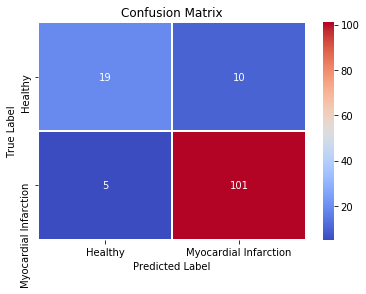

              precision    recall  f1-score   support

           0       0.79      0.66      0.72        29
           1       0.91      0.95      0.93       106

    accuracy                           0.89       135
   macro avg       0.85      0.80      0.82       135
weighted avg       0.88      0.89      0.88       135



In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    pyplot.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                annot=True,
                fmt='d')
    pyplot.title('Confusion Matrix')
    pyplot.ylabel('True Label')
    pyplot.xlabel('Predicted Label')
    pyplot.show()

#X_test = X_test.reshape(X_test.shape[0], input_shape)

y_pred_test = model.predict(X_test, verbose = 1)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
#max_y_test = np.argmax(Y_test, axis=1)

#X_test = X_test.reshape(X_test.shape[0], input_shape)

show_confusion_matrix(Y_test, max_y_pred_test)

print(classification_report(Y_test, max_y_pred_test))